In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [15]:
# parse logging data
per_layer_loss = {i: [] for i in range(32)}
with open("/root/loss_norm_data/log.txt") as f:
    for line in f:
        if "mean loss per token" in line:
            layer_id = int(line.split("layer")[1].split()[0].strip())
            try:
                mean_loss_per_token = line.split("mean loss per token:")[1].strip()
                if mean_loss_per_token == "None":
                    continue
                mean_loss_per_token = float(mean_loss_per_token)
                if mean_loss_per_token < 1e-5:
                    continue
            except:
                print(line)
                break
            per_layer_loss[layer_id].append(mean_loss_per_token)


per_layer_avg_loss = {}
for layer_id, losses in per_layer_loss.items():
    per_layer_avg_loss[layer_id] = sum(losses) / len(losses)

In [16]:
# plot per layer loss distribution
layer_ids = []
losses = []
for layer_id, loss in per_layer_loss.items():
    for l in loss:
        layer_ids.append(layer_id)
        losses.append(l)

df = pd.DataFrame({"layer_id": layer_ids, "loss": losses})

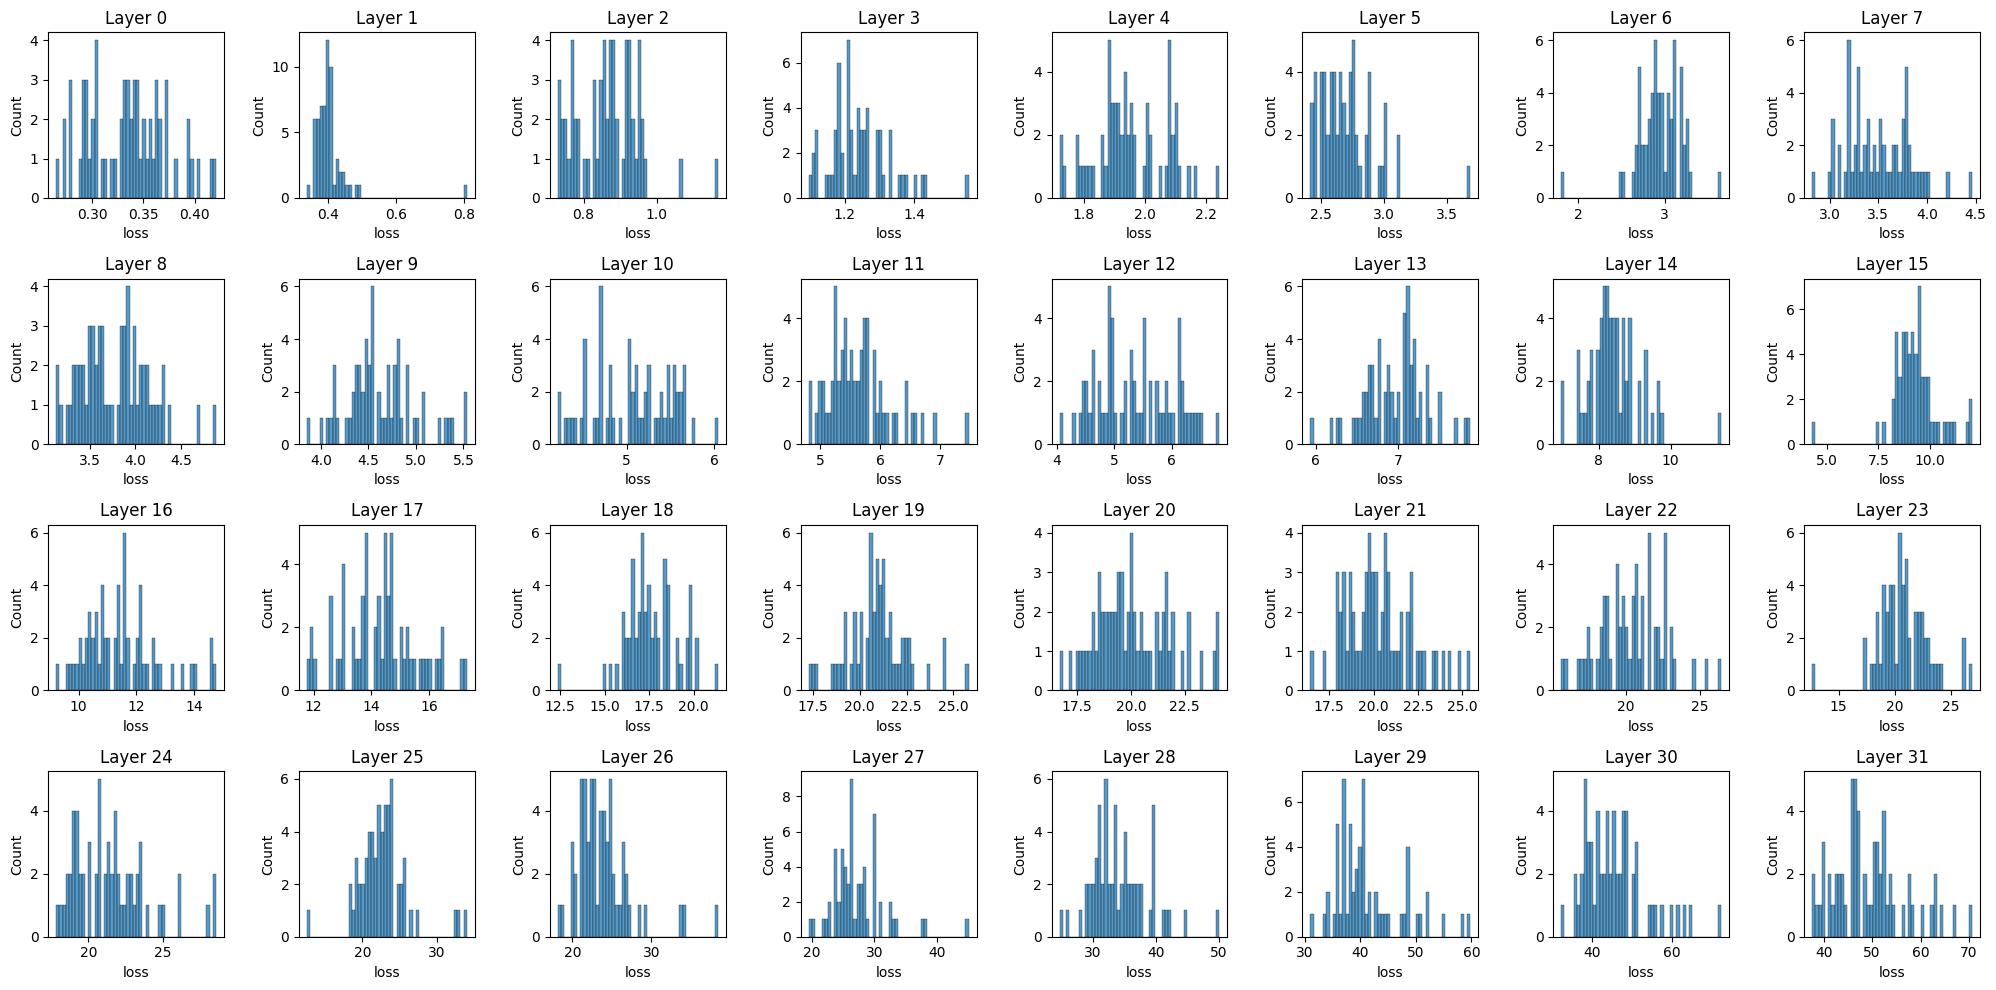

In [23]:
fig, axes = plt.subplots(4, 8, figsize=(20,10))
for i in range(32):
    ax = axes[i//8, i%8]
    sns.histplot(df[df["layer_id"] == i]["loss"], ax=ax, bins=50)
    ax.set_title(f"Layer {i}")
plt.tight_layout()

In [4]:
fig.savefig("per_layer_loss_distribution.pdf", bbox_inches='tight')

NameError: name 'fig' is not defined

In [17]:
eval_df = pd.read_csv("/root/loss_norm_data/neuron_importance_eval.csv")

In [18]:
# read quantization data
WBITS = [2, 3]
quantization_losses = {}
for expert_id in range(8):
    for layer_id in range(32):
        for wbits in WBITS:
            with open(os.path.join("/root/gptq_experts", f"e{expert_id}_l{layer_id}_w{wbits}", "diff_norm.txt"), "r") as f:
                diff_norm = float(f.read().strip())
                quantization_losses[(expert_id, layer_id, wbits)] = diff_norm

per_layer_avg_loss_quant = {w: {i: 0 for i in range(32)} for w in WBITS}
for (expert_id, layer_id, wbits), diff_norm in quantization_losses.items():
    per_layer_avg_loss_quant[wbits][layer_id] += diff_norm

for wbits in WBITS:
    for layer_id in range(32):
        per_layer_avg_loss_quant[wbits][layer_id] /= 8

In [19]:
# read merged data
merged_losses = {}
for layer_id in range(32):
    with open(os.path.join("/root/merged_experts", f"w2_l{layer_id}", "diffs.txt"), "r") as f:
        for line in f:
            norm = float(line.split("Mean diff: ")[1].split("-")[0].strip())
            merged_losses[layer_id] = norm

In [11]:
mean_cluster_losses = cluster_losses.groupby(["layer_id", "n_clusters"])["mean_distance"].mean().reset_index()

In [12]:
mean_cluster_losses

,layer_id,n_clusters,mean_distance
0,0,2,0.805176
1,0,4,0.787109
2,0,8,0.779785
3,0,16,0.769043
4,0,32,0.758301
...,...,...,...
411,31,512,109.812500
412,31,1024,106.562500
413,31,2048,102.625000
414,31,4096,97.875000


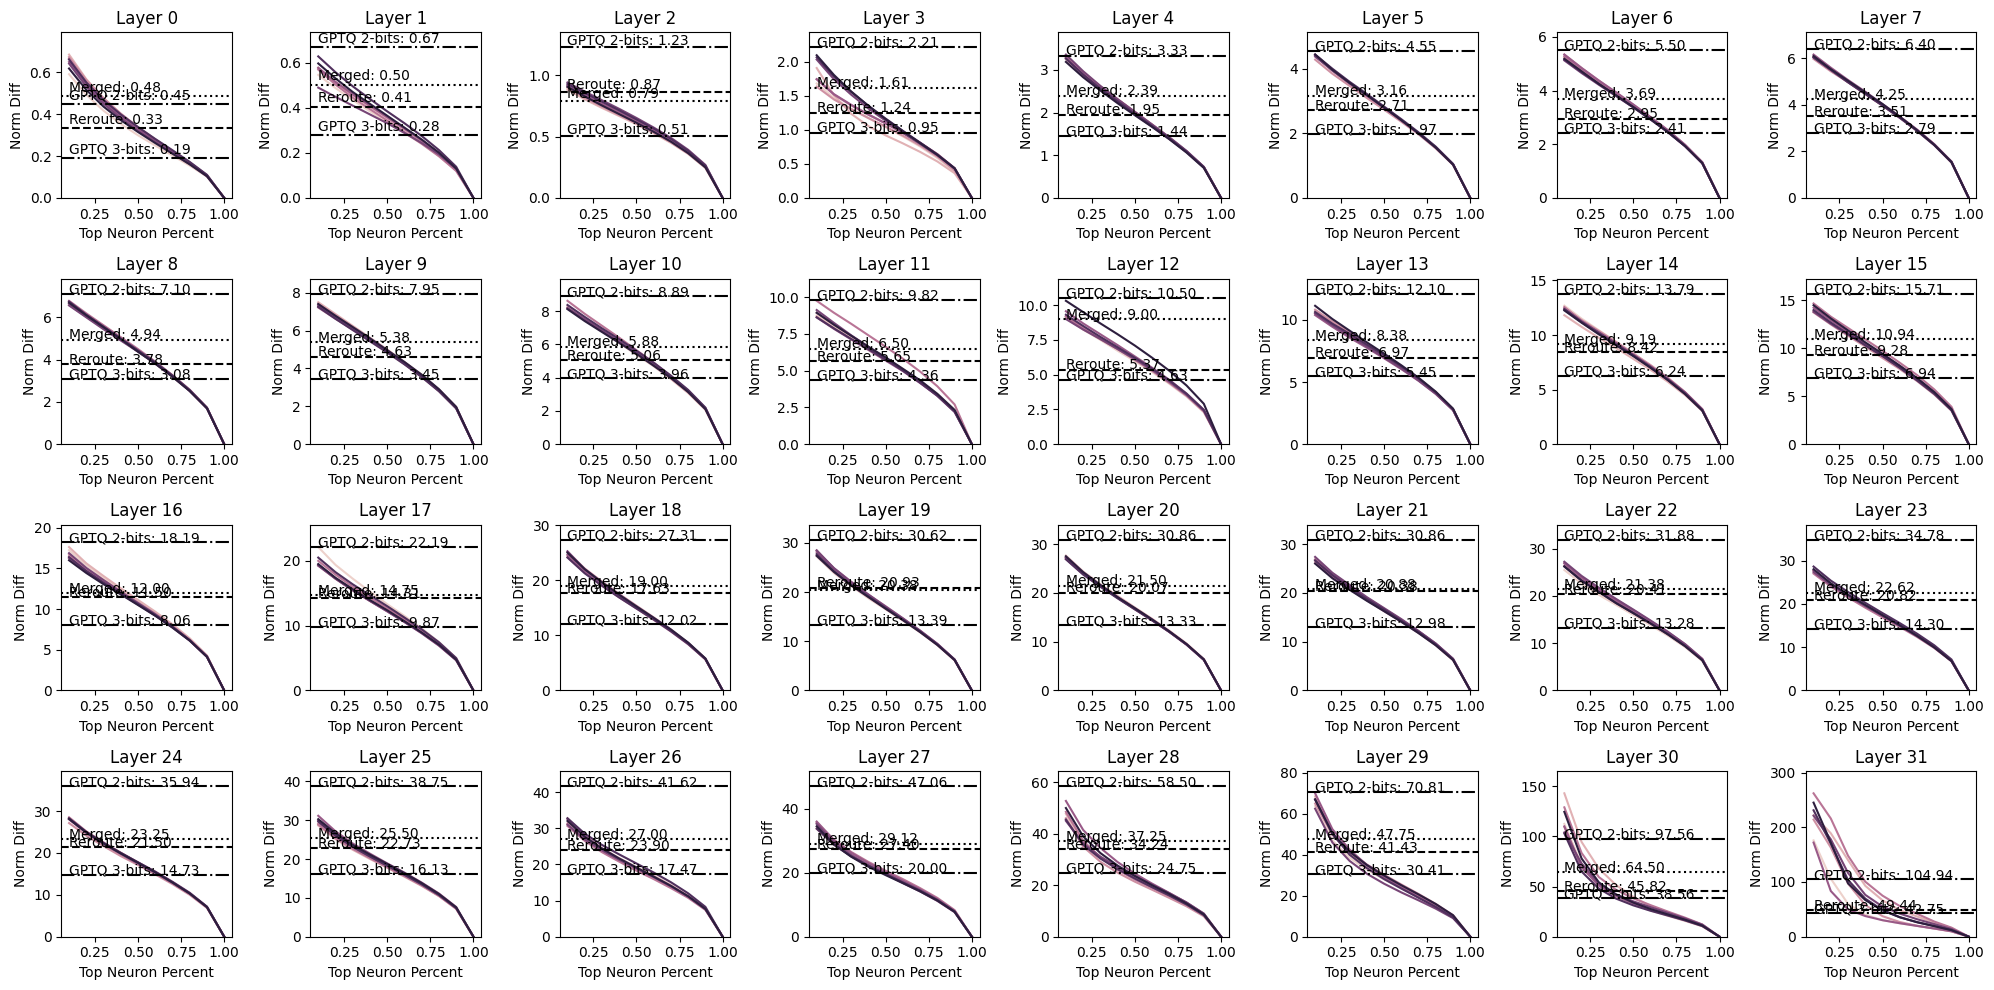

In [9]:
# plot
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    ax = axes[i // 8, i % 8]
    sns.lineplot(x="top_neuron_percent", y="norm_diff", data=eval_df[eval_df["layer_id"] == i], hue="expert_id", ax=ax)
    ax.legend().remove()
    # draw a line for the average loss
    ax.axhline(per_layer_avg_loss[i], color="black", linestyle="--")
    ax.text(0.1, per_layer_avg_loss[i] + 0.02, f"Reroute: {per_layer_avg_loss[i]:.2f}")
    # draw a line for each quantization level
    max_y = max(per_layer_avg_loss[i], ax.get_ylim()[1])
    for wbits in WBITS:
        ax.axhline(per_layer_avg_loss_quant[wbits][i], color="black", linestyle="-.")
        ax.text(0.1, per_layer_avg_loss_quant[wbits][i] + 0.02, f"GPTQ {wbits}-bits: {per_layer_avg_loss_quant[wbits][i]:.2f}")
        max_y = max(max_y, per_layer_avg_loss_quant[wbits][i])
    # draw a line for merged expert
    if i != 31:
        ax.axhline(merged_losses[i], color="black", linestyle=":")
        ax.text(0.1, merged_losses[i] + 0.02, f"Merged: {merged_losses[i]:.2f}")
        max_y = max(max_y, merged_losses[i])
    ax.set_ylim(0, max_y * 1.1)

    ax.set_title(f"Layer {i}")
    ax.set_xlabel("Top Neuron Percent")
    ax.set_ylabel("Norm Diff")
plt.tight_layout()

In [16]:
fig.savefig("neuron_importance_eval.pdf", bbox_inches="tight")

In [20]:
# read clustering data
cluster_losses = pd.read_csv("/root/vllm/benchmarks/weight_explorer/RANSAC/kmeans_results_small.csv")
mean_cluster_losses = cluster_losses.groupby(["layer_id", "n_clusters"])["mean_distance"].mean().reset_index()

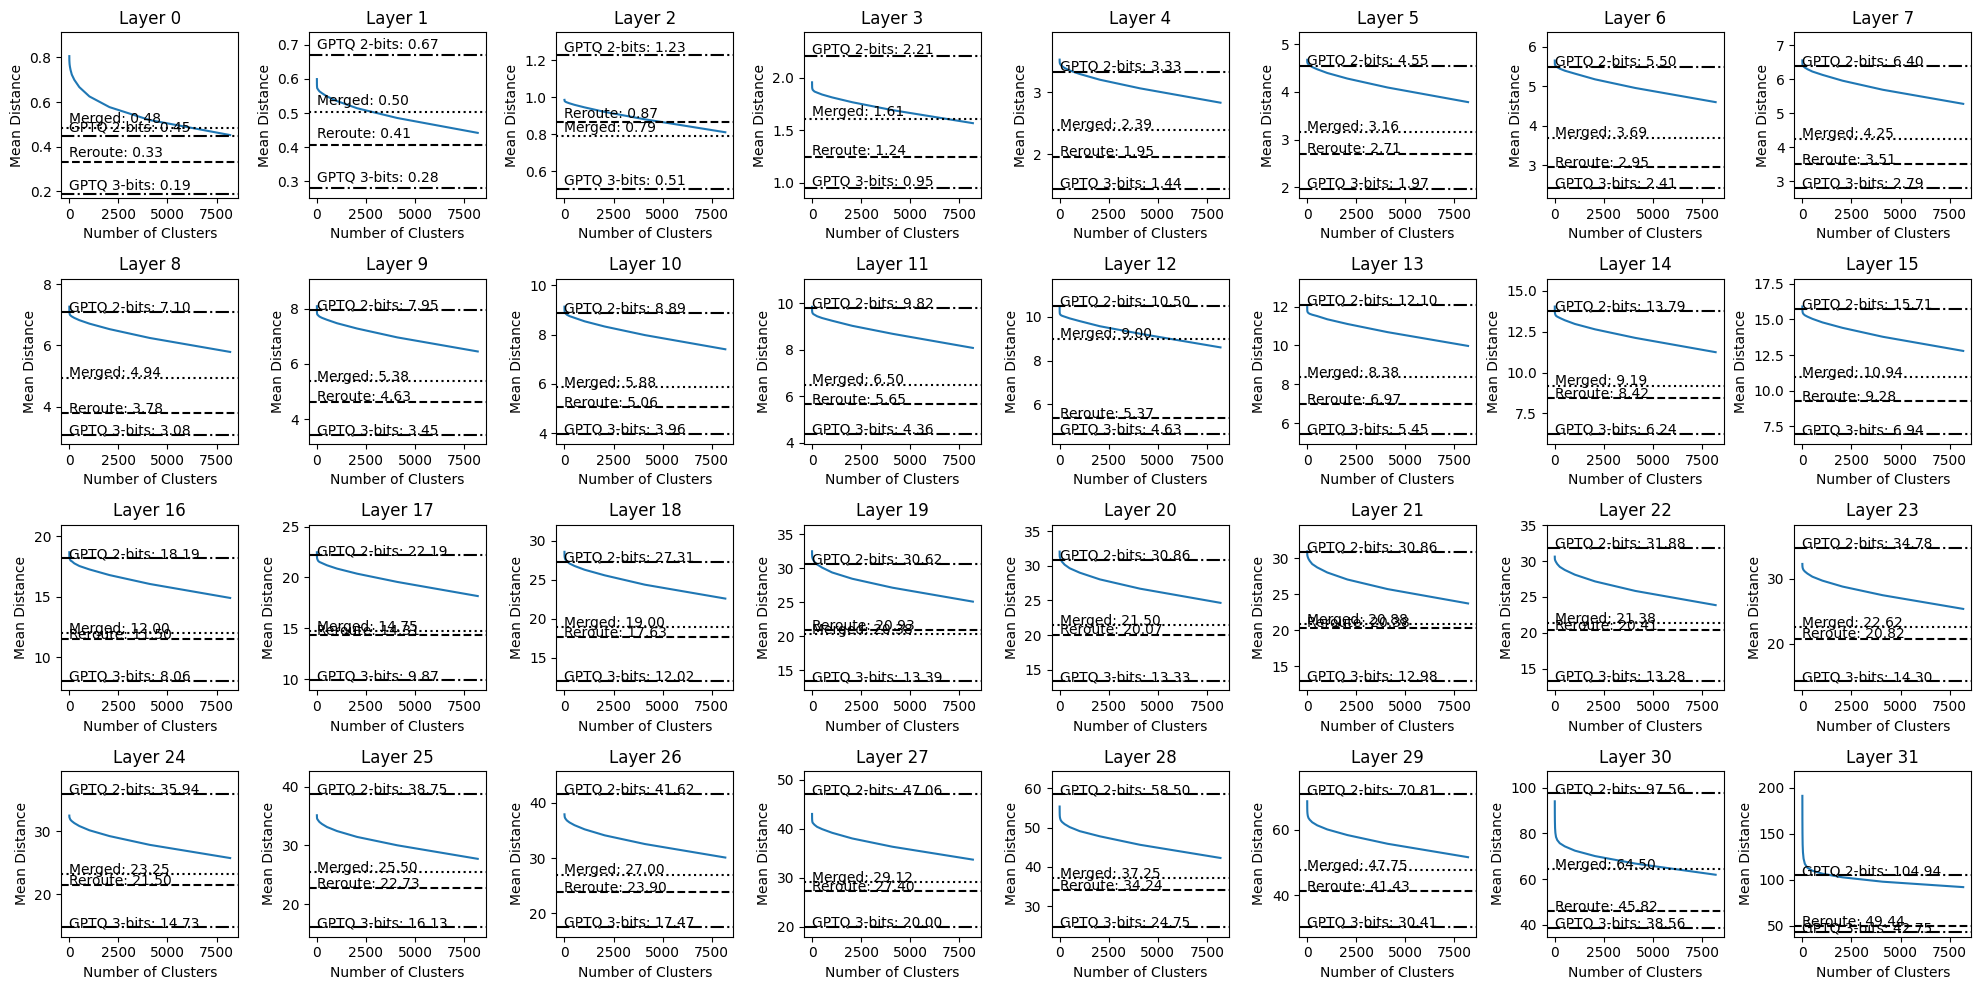

In [22]:
# plot
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    ax = axes[i // 8, i % 8]
    sns.lineplot(x="n_clusters", y="mean_distance", data=mean_cluster_losses[mean_cluster_losses["layer_id"] == i], ax=ax)
    # draw a line for the average loss
    ax.axhline(per_layer_avg_loss[i], color="black", linestyle="--")
    ax.text(0.1, per_layer_avg_loss[i] + 0.02, f"Reroute: {per_layer_avg_loss[i]:.2f}")
    # draw a line for each quantization level
    max_y = max(per_layer_avg_loss[i], ax.get_ylim()[1])
    min_y = min(per_layer_avg_loss[i], ax.get_ylim()[0])
    for wbits in WBITS:
        ax.axhline(per_layer_avg_loss_quant[wbits][i], color="black", linestyle="-.")
        ax.text(0.1, per_layer_avg_loss_quant[wbits][i] + 0.02, f"GPTQ {wbits}-bits: {per_layer_avg_loss_quant[wbits][i]:.2f}")
        max_y = max(max_y, per_layer_avg_loss_quant[wbits][i])
        min_y = min(min_y, per_layer_avg_loss_quant[wbits][i])
    # draw a line for merged expert
    if i != 31:
        ax.axhline(merged_losses[i], color="black", linestyle=":")
        ax.text(0.1, merged_losses[i] + 0.02, f"Merged: {merged_losses[i]:.2f}")
        max_y = max(max_y, merged_losses[i])
        min_y = min(min_y, merged_losses[i])
    ax.set_ylim(min_y * 0.9, max_y * 1.1)
    ax.set_title(f"Layer {i}")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Mean Distance")
plt.tight_layout()

In [ ]:
fig.savefig("cluster_eval.pdf", bbox_inches="tight")